In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Define the dataset name and version
dataset_name = "squad"
# dataset_version = "wikitext-103-raw-v1"

# Load the dataset from Hugging Face
dataset = load_dataset(dataset_name) #, dataset_version)
train_dataset = dataset['train']
valid_dataset = dataset['validation']

# load train and validation split of squad
# train_dataset  = nlp.load_dataset('squad', split=nlp.Split.TRAIN)
# valid_dataset = nlp.load_dataset('squad', split=nlp.Split.VALIDATION)


# Define the device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the T5 model and tokenizer
# model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
# tokenizer = T5Tokenizer.from_pretrained('t5-base')
from transformers import  AutoTokenizer, AutoModelWithLMHead, pipeline
model_name = "MaRiOrOsSi/t5-base-finetuned-question-answering"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)

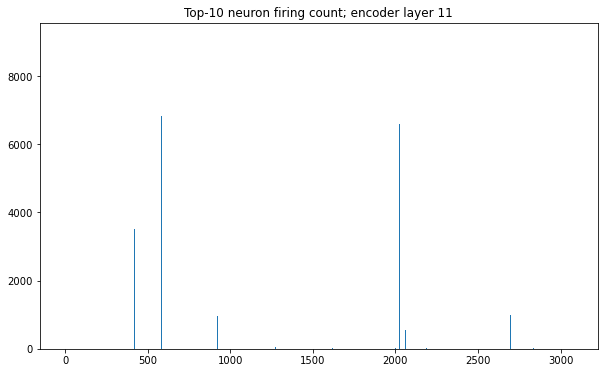

In [10]:
from plotting import plot_topk
counts = plot_topk(11, k=10, encoder=True, log_scale=False)

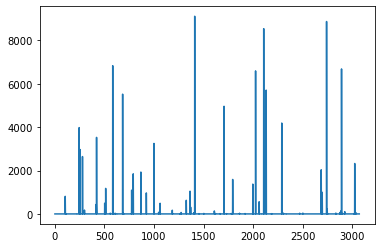

In [7]:
import matplotlib.pyplot as plt
plt.plot(counts)

In [ ]:
def getActivation(name, activation):
  # the hook signature
    def hook(model, input, output):
        if name not in activation.keys():
            activation[name] = [output.detach()]
        else:
            activation[name].append(output.detach())
    return hook

In [8]:
import pickle
with open("interpretable_neurons_100_200_d12.pkl", "rb") as fp:
    interpretable_neurons = pickle.load(fp)

In [9]:
interpretable_neurons

{42: ' electrical engineering, Tesla, power systems.',
 46: ' education, labor, inequality.',
 51: '\n- Conference, Receive, Business: professional events\n- War, Election, Politics: government and conflict\n- Science,',
 60: ' history, religion, government.',
 88: ' sports commentary, historical figures and events, names and places.',
 131: ' cities and universities',
 178: ' German geography and historical figures, engineering and academia.',
 253: ' NFL-related terms, Super Bowl-related terms, City of San Jose.',
 331: ' locations (mostly North America, UK, Australia), historical figures, railway engineering.',
 344: ' names (John, Marshall, Jim, Mick), measurements (million, meters, miles), places (Melbourne, Mongolia, Kenya).',
 361: ' Civil Rights, Protestants, Silk Road.',
 381: ' geographical locations, historical figures, numbers.',
 407: ' education, schools, universities',
 415: ' immunology, photosynthesis, chloroplasts.',
 442: ' religious sites/events, football, TV progra

In [ ]:
# TESTING CELL: put in one input, test for similarity between output length and number of elements in "activation"
question = "What my mother's name?"
context = "My mother's name is Ann Marjorie Saberi."
input = f"question: {question} context: {context}"
encoded_input = tokenizer([input],
                             return_tensors='pt',
                             max_length=512,
                             truncation=True)
# Register hooks
handles = []
activation = {}
for name, module in model.named_modules():
    if "act" in name:
        handles.append(module.register_forward_hook(getActivation(name, activation)))

output = model.generate(input_ids = encoded_input.input_ids,
                            attention_mask = encoded_input.attention_mask)
print(output.size())
output = tokenizer.decode(output[0], skip_special_tokens=True)
print(output)

# Remove hooks (we can only use them once!)
for handle in handles:
    handle.remove()

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset

# Load the SQuAD dataset
dataset = load_dataset("squad", split="validation")

# initialize sparsities dict
sparsities = {}

# Iterate over the dataset and feed it into the model
with torch.no_grad():
    for example in dataset:
        # Get the input and target text from the example
        input_text = f"question: {example['question']} context: {example['context']}"
        target_text = example["answers"]["text"][0]

        # Register hooks
        handles = []
        activation = {}
        for name, module in model.named_modules():
            if "act" in name:
                handles.append(module.register_forward_hook(getActivation(name, activation)))

        # Tokenize the input and target text
        input_ids = tokenizer.encode(input_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
        target_ids = tokenizer.encode(target_text, padding=True, truncation=True, max_length=32, return_tensors="pt")

        # Generate the output from the model
        output_ids = model.generate(input_ids)

        # Compute sparsities, after forward pass
        for key in activation.keys():
            hidden_states = torch.cat(activation[key])
            if key not in sparsities.keys():
                sparsities[key] = [len(torch.nonzero(hidden_states))/torch.numel(hidden_states)]
            else:
                sparsities[key].append(len(torch.nonzero(hidden_states))/torch.numel(hidden_states))

        # Remove hooks (we can only use them once!)
        for handle in handles:
            handle.remove()

        # Decode the output and print the results
      #  output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
      #  print("Input Text:", input_text)
      #  print("Target Text:", target_text)
      #  print("Generated Text:", output_text)

In [ ]:
import numpy as np
avg_sparsities = {}
for key in sparsities.keys():
    s = np.array(sparsities[key])
    avg_sparsities[key] = np.mean(s)

In [ ]:
import matplotlib.pyplot as plt
names = list(avg_sparsities.keys())
shortened_names = []
for i in range(24):
    if i < 12:
        shortened_names.append("e" + str(i+1))
    else:
        shortened_names.append("d" + str(i%12+1))
values = list(avg_sparsities.values())
plt.figure(figsize=(10,6))
plt.bar(range(len(avg_sparsities)), values, tick_label=shortened_names)
plt.title("Average sparsity of activation layers")
plt.show()

In [2]:
import pickle
with open('interpretable_neurons_100_200_d12.pkl', 'rb') as fp:
    interpretable_neurons = pickle.load(fp)

In [3]:
interpretable_neurons

{42: ' electrical engineering, Tesla, power systems.',
 46: ' education, labor, inequality.',
 51: '\n- Conference, Receive, Business: professional events\n- War, Election, Politics: government and conflict\n- Science,',
 60: ' history, religion, government.',
 88: ' sports commentary, historical figures and events, names and places.',
 131: ' cities and universities',
 178: ' German geography and historical figures, engineering and academia.',
 253: ' NFL-related terms, Super Bowl-related terms, City of San Jose.',
 331: ' locations (mostly North America, UK, Australia), historical figures, railway engineering.',
 344: ' names (John, Marshall, Jim, Mick), measurements (million, meters, miles), places (Melbourne, Mongolia, Kenya).',
 361: ' Civil Rights, Protestants, Silk Road.',
 381: ' geographical locations, historical figures, numbers.',
 407: ' education, schools, universities',
 415: ' immunology, photosynthesis, chloroplasts.',
 442: ' religious sites/events, football, TV progra